# PLS, di-PLS and mdi-PLS models for the prediction of DMC
### Load modules

In [237]:
# --- system modules

import sys
import datetime
import os


# --- numerical modules

import numpy as np
import pandas as pd


# --- model building

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


# --- diPLS

import functions as fct
import dipals as ml
import utils 


# --- visualization and data modules
import matplotlib as mtply
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


plt.style.use("ggplot")
plt.rcParams.update({'font.size': 20})

### Load data

In [238]:
data_url = "NAnderson2020MendeleyMangoNIRData.csv"
data_raw = pd.read_csv(data_url,sep = ",", decimal = ".")

### Define source and target domains
Here the common cultivars for the 4 seasons are Caly, KP, HG, R2E2, therefore we keep those 4 cultivars. Cultivar Caly is kept in the source domain with season 1. The other cultivars are taken in the target domains for seasons 1,2 and 3. The test set is called "Val Ext" and it contains data of season 4 and we take all the other conditions.

In [239]:
sou_filter = (data_raw["Season"]==1) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "Caly")

tar_filters = []
tar_filters.append((data_raw["Season"]==1) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "KP"))
tar_filters.append((data_raw["Season"]==1) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "HG"))
tar_filters.append((data_raw["Season"]==2) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "KP"))
tar_filters.append((data_raw["Season"]==2) &  (data_raw["Set"] == "Tuning") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "HG"))
tar_filters.append((data_raw["Season"]==2) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "R2E2"))
tar_filters.append((data_raw["Season"]==3) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "KP"))
tar_filters.append((data_raw["Season"]==3) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "HG"))
tar_filters.append((data_raw["Season"]==3) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "R2E2"))
tar_filters.append((data_raw["Season"]==3) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Ripen") & (data_raw["Cultivar"] == "KP"))

# season 4
tar_test_filter = (data_raw["Set"]=="Val Ext") & (data_raw["Region"] == "NT") & ((data_raw["Type"] == "Hard Green") | (data_raw["Type"] == "Ripen") ) & ((data_raw["Cultivar"] == "Caly") | (data_raw["Cultivar"] == "KP") | (data_raw["Cultivar"] == "HG") | (data_raw["Cultivar"] == "R2E2"))

# data shapes
print(sou_filter.head())
print(sou_filter.sum(), [tt_filter.sum() for tt_filter in tar_filters],tar_test_filter.sum())

0    True
1    True
2    True
3    True
4    True
dtype: bool
1277 [1059, 293, 340, 88, 276, 216, 80, 156, 78] 702


In [240]:
# Get data sets for each domain
data_sou = data_raw.loc[sou_filter]
data_tar_list = []
for tt_filter in tar_filters:    
    data_tar_list.append(data_raw.loc[tt_filter])
    
data_tar_test = data_raw.loc[tar_test_filter]

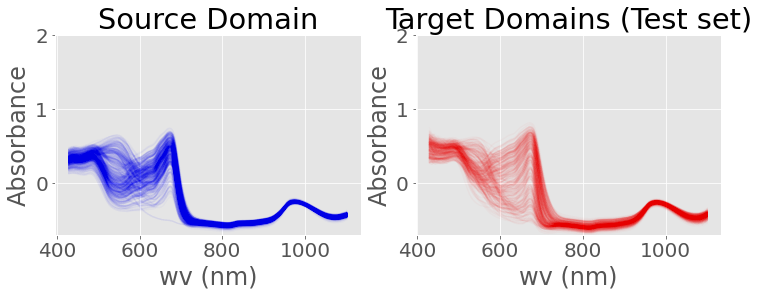

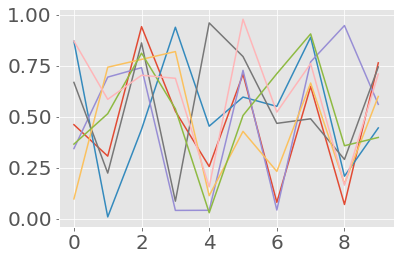

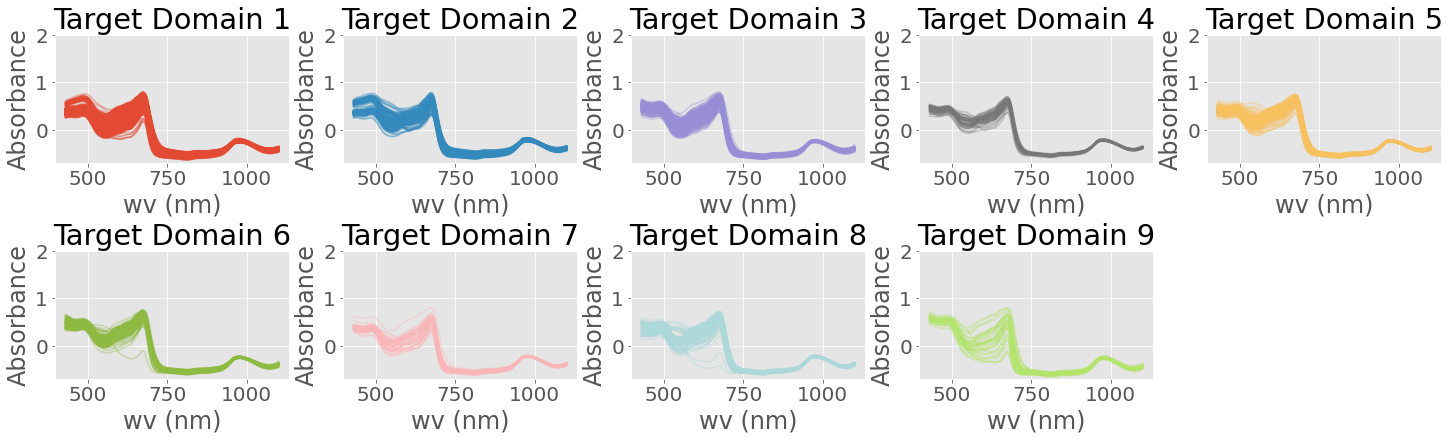

In [241]:
# Get matrices for each domain
wv_range_selected = np.arange(40,265) # 430-1100 nm
Xsou_cal = np.array(data_sou.iloc[:,17:-14])[:,wv_range_selected]
Ysou_cal = np.array(data_sou.iloc[:,8:9])

Xt_list = []
yt_list = []

for data_tar in data_tar_list:    
    Xt_list.append(np.array(data_tar.iloc[:,17:-14])[:,wv_range_selected])
    yt_list.append(np.array(data_tar.iloc[:,8:9]))

Xtar_test = np.array(data_tar_test.iloc[:,17:-14])[:,wv_range_selected]
Ytar_test = np.array(data_tar_test.iloc[:,8:9])
wv_range = np.array(data_sou.columns[17:-14]).astype(np.float64)[wv_range_selected]

# spectral signals from each domain
ymin = -0.7
ymax = 2

fig, axs = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True)

axs[0].plot(wv_range,Xsou_cal.T,c="blue", alpha=0.01)
axs[0].set_ylim(ymin, ymax)
axs[0].set_title("Source Domain")
axs[0].set_xlabel("wv (nm)")
axs[0].set_ylabel("Absorbance")

axs[1].plot(wv_range,Xtar_test.T,c="red", alpha=0.01)
axs[1].set_ylim(ymin, ymax)
axs[1].set_title("Target Domains (Test set)")
axs[1].set_xlabel("wv (nm)")
axs[1].set_ylabel("Absorbance")
plt.show()

color_list = []
for i in range(7):
    p, = plt.plot(np.random.random(10))
    color_list.append(p.get_color())

color_list.append("#ADD8DA")
color_list.append("#B4E36B")
color_list.append("#D7ADDA")
color_list.append("#BDDAAD")
color_list.append("#7AC4A1")

fig, axs = plt.subplots(2, 5, figsize=(20,6), constrained_layout=True)
k = 0

for i in range(2):
    for j in range(5):        
        if k < 9:
            axs[i,j].plot(wv_range,Xt_list[k].T, c=color_list[k], alpha=0.2)
            axs[i,j].set_ylim(ymin, ymax)
            axs[i,j].set_title("Target Domain {:d}".format(k+1))
            axs[i,j].set_xlabel("wv (nm)")
            axs[i,j].set_ylabel("Absorbance")            
            k += 1

axs[-1,-1].axis('off')
plt.show()

### Build models

In [242]:
# Prepare data
X = Xsou_cal.copy()
Xs = X.copy()
Y = Ysou_cal.copy()

# For mdipls
target_domains = Xt_list.copy()

# For dipls with concatenation
Xtar_concat = np.concatenate(Xt_list, axis = 0) 
target_domains_concat = [Xtar_concat]

#### Set meta parameters

In [243]:
chosen_lv_pls = 19     
chosen_lv_dipls = 16   
chosen_lv_mdipls = 8  

chosen_lambda_dipls = 1e8
chosen_lambda_mdipls = 1e7

#### Scores plots

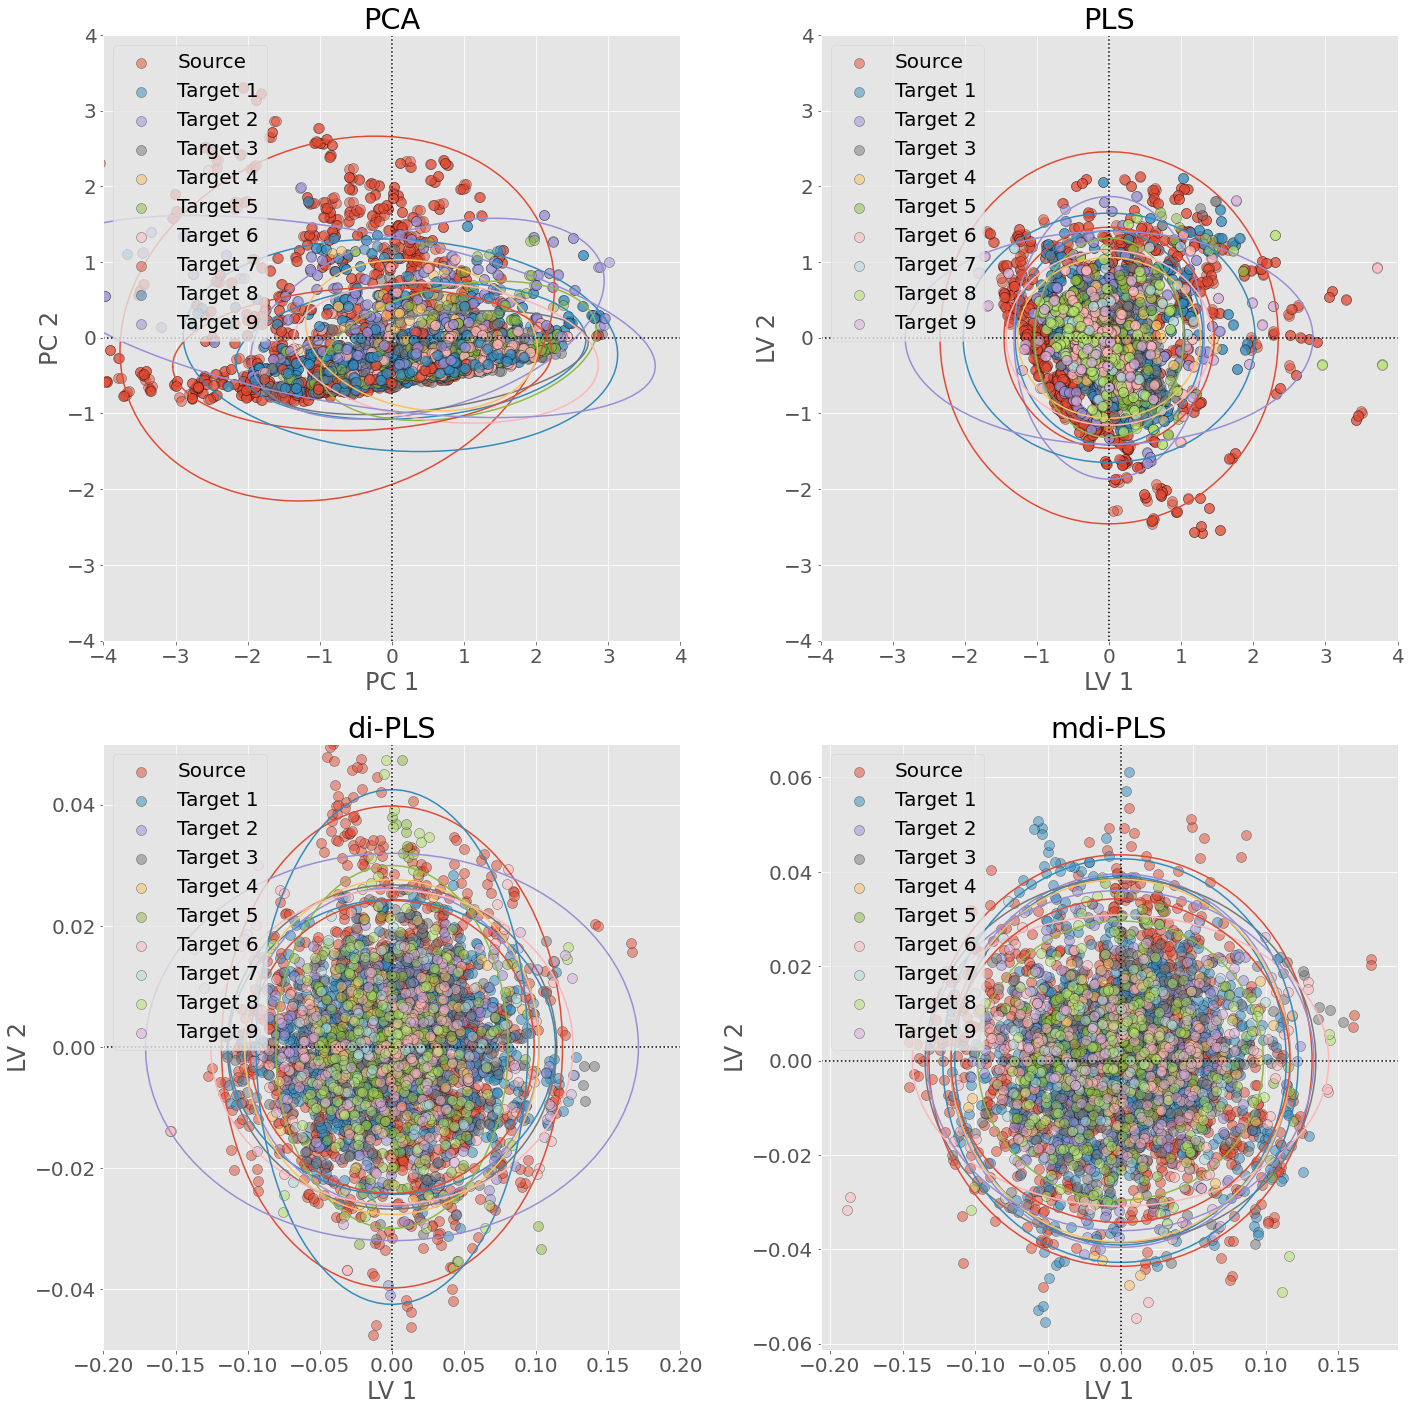

In [244]:
### PCA
n_id = np.cumsum([0,Xsou_cal.shape[0]] + [xx.shape[0] for xx in Xt_list])
X_pca = np.vstack([Xsou_cal] + Xt_list)
X_pca = X_pca[:,...] - np.mean(X_pca,0)
U,S,V = np.linalg.svd(X_pca)
T = U[:, :20]@np.diag(S[:20])
pca_var_explained = 100*(S**2/np.sum(S**2)) # add the percentage to the figure

plt.figure(figsize=(20,20))
plt.subplot(221)
figs = []

for i in range(n_id.shape[0]-1):
    rows = np.arange(n_id[i],n_id[i+1])
    a = plt.scatter(T[rows, 0], T[rows, 1], edgecolors='k', marker="o", s=100, alpha=0.5)
    figs.append(a)
    el = fct.hellipse(T[rows, :2])
    plt.plot(el[0,:],el[1,:])

plt.xlabel('PC 1')
plt.ylabel('PC 2')

ax = plt.gca()
ax.axhline(y=0,color='k',linestyle=':')
ax.axvline(x=0,color='k',linestyle=':')
plt.xlim([-4,4])
plt.ylim([-4,4])

plt.legend(figs, ['Source'] + ["Target {:d}".format(k) for k in range(1,10)])
plt.title('PCA')
#plt.savefig("./figures/mango_pca.png")
#plt.plot()

### PLS
m = ml.model(X, Y, Xs, target_domains, chosen_lv_pls)
l = [0]
m.fit(l=l, target_domain=0)

figs = []
plt.subplot(222)
a = plt.scatter(m.Ts[:, 0], m.Ts[:, 1], edgecolors='k', marker="o", s=100, alpha=0.5, c=color_list[0], label="Source") # Plots Source Domain
el = fct.hellipse(m.Ts)
plt.plot(el[0,:],el[1,:])
figs.append(a)

for i in range(len(target_domains)): # Plots target domains    
    b = plt.scatter(m.Tt[i][:, 0], m.Tt[i][:, 1], edgecolors='k', marker="o", s=100, alpha=0.5, c=color_list[i+1], label="Target {:d}".format(i+1))
    el = fct.hellipse(m.Tt[i])
    plt.plot(el[0,:],el[1,:])
    figs.append(b)

ax = plt.gca()
ax.axhline(y=0,color='k',linestyle=':')
ax.axvline(x=0,color='k',linestyle=':')
plt.xlim([-4,4])
plt.ylim([-4,4])

plt.legend(loc=2)
plt.xlabel('LV 1')
plt.ylabel('LV 2')
plt.title('PLS')

plt.tight_layout()
#plt.savefig("./figures/mango_pls.png")

### di-PLS
m = ml.model(X, Y, Xs, target_domains_concat, chosen_lv_dipls)
l = [chosen_lambda_dipls]
m.fit(l=l, target_domain=0)

T_dipls = []
for ti in range(len(target_domains)):  
    Xt_c = target_domains[ti] - target_domains[ti].mean(axis=0)
    TT = np.zeros((Xt_c.shape[0],2))
    for j in range(2):
        tt = Xt_c.dot(m.W[:,j:(j+1)])
        TT[:,j] = tt.flatten()
        pt = (tt.T@Xt_c)/(tt.T@tt)
        Xt_hat_c = tt.dot(pt)
        Xt_c = Xt_c - Xt_hat_c    
    T_dipls.append(TT)

figs = []

plt.subplot(223)
a = plt.scatter(m.Ts[:, 0], m.Ts[:, 1], edgecolors='k', marker="o", s=100, alpha=0.5, c=color_list[0], label="Source")
el = fct.hellipse(m.Ts)
plt.plot(el[0,:],el[1,:])
figs.append(a)

for i in range(len(target_domains)):    
    b = plt.scatter(T_dipls[i][:, 0], T_dipls[i][:, 1], edgecolors='k', marker="o", s=100, alpha=0.5, c=color_list[i+1], label="Target {:d}".format(i+1))
    el = fct.hellipse(T_dipls[i])
    plt.plot(el[0,:],el[1,:])    
    figs.append(b)

ax = plt.gca()
ax.axhline(y=0,color='k',linestyle=':')
ax.axvline(x=0,color='k',linestyle=':')

# plt.legend(figs, ['Source'] + ["Target all"])
plt.legend(loc=2)
plt.xlabel('LV 1')
plt.ylabel('LV 2')
plt.title('di-PLS')
plt.xlim([-0.2,0.2])
plt.ylim([-0.05,0.05])
plt.tight_layout()

### mdi-PLS
m = ml.model(X, Y, Xs, target_domains, chosen_lv_mdipls)
l = [chosen_lambda_mdipls]
m.fit(l=l, target_domain=0)

figs = []
plt.subplot(224)
a = plt.scatter(m.Ts[:, 0], m.Ts[:, 1], edgecolors='k', marker="o", s=100, alpha=0.5, c=color_list[0], label="Source")
el = fct.hellipse(m.Ts[:, 0:2])
plt.plot(el[0,:],el[1,:])
figs.append(a)
for i in range(len(target_domains)):
    b = plt.scatter(m.Tt[i][:, 0], m.Tt[i][:, 1], edgecolors='k', marker="o", s=100, alpha=0.5, c=color_list[i+1], label="Target {:d}".format(i+1))
    el = fct.hellipse(m.Tt[i][:, 0:2])
    plt.plot(el[0,:],el[1,:])    
    figs.append(b)

ax = plt.gca()
ax.axhline(y=0,color='k',linestyle=':')
ax.axvline(x=0,color='k',linestyle=':')

plt.legend(loc=2)
plt.xlabel('LV 1')
plt.ylabel('LV 2')
plt.title('mdi-PLS')
plt.tight_layout()

plt.savefig("../figures/mango_allscores.png")

In [245]:
pls_var_explained_source_df = pd.DataFrame.from_dict(utils.xvar_mdipls(m.W, [Xs], 3, "Source"), orient="index")
print(pls_var_explained_source_df.to_latex())
pls_var_explained_target_df = pd.DataFrame.from_dict(utils.xvar_mdipls(m.W, target_domains, 3, "Target"), orient="index")
print(pls_var_explained_target_df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  \% LV 1 &  \% LV 2 &  \% LV 3 \\
\midrule
Source 1 &   11.26 &   40.67 &   33.38 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
{} &  \% LV 1 &  \% LV 2 &  \% LV 3 \\
\midrule
Target 1 &   14.86 &   44.20 &   35.19 \\
Target 2 &   14.57 &   59.62 &   21.26 \\
Target 3 &   15.00 &   45.92 &   32.82 \\
Target 4 &   11.29 &   33.30 &   44.01 \\
Target 5 &   13.55 &   28.81 &   50.33 \\
Target 6 &   14.69 &   29.88 &   47.17 \\
Target 7 &   21.66 &   34.78 &   38.33 \\
Target 8 &   34.00 &   41.64 &   13.79 \\
Target 9 &   32.96 &   14.80 &   29.94 \\
\bottomrule
\end{tabular}



### Model training

In [246]:
# Source model (PLS)
m_pls = ml.model(X, Y, Xs, target_domains, chosen_lv_pls)
l = [0]
m_pls.fit(l=l, target_domain=0)
b_pls = m_pls.b

# Invariant model (di-PLS)
m_dipls = ml.model(X, Y, Xs, target_domains_concat, chosen_lv_dipls)
l = [chosen_lambda_dipls]
m_dipls.fit(l=l, target_domain=0)
b_dipls = m_dipls.b

# Multi Invariant model (mdi-PLS)
m_mdipls = ml.model(X, Y, Xs, target_domains, chosen_lv_mdipls)
l = [chosen_lambda_mdipls]
m_mdipls.fit(l=l, target_domain=0)
b_mdipls = m_mdipls.b

### Model performance in target domains

In [247]:
XX = np.concatenate(target_domains, axis = 0) 
YY = np.concatenate(yt_list, axis = 0) 
print(XX.shape)
print(YY.shape)

yhat_pls, err_pls = m_pls.predict(XX, YY)
yhat_dipls, err_dipls = m_dipls.predict(XX, YY)
yhat_mdipls, err_mdipls = m_mdipls.predict(XX, YY)

rmsep_pls, bias_pls, r2p_pls, sep_pls = utils.performance_measures(YY, yhat_pls)
rmsep_dipls, bias_dipls, r2p_dipls, sep_dipls = utils.performance_measures(YY, yhat_dipls)
rmsep_mdipls, bias_mdipls, r2p_mdipls, sep_mdipls = utils.performance_measures(YY, yhat_mdipls)

table = []
model_performance = {}
model_performance["Property"] = "DMC"
model_performance["Model"] = "PLS"
model_performance["LV"] = chosen_lv_pls
model_performance["Regularization"] = None
model_performance["RMSEP (target)"] = "{:.2f}".format(rmsep_pls)
model_performance["R2P (target)"] = "{:.2f}".format(r2p_pls)
model_performance["Bias (target)"] = "{:.2f}".format(bias_pls)
model_performance["SEP (target)"] = "{:.2f}".format(sep_pls)
table.append(model_performance)

model_performance = {}
model_performance["Property"] = "DMC"
model_performance["Model"] = "di-PLS"
model_performance["LV"] = chosen_lv_dipls
model_performance["Regularization"] = "{:.0e}".format(chosen_lambda_dipls)
model_performance["RMSEP (target)"] = "{:.2f}".format(rmsep_dipls)
model_performance["R2P (target)"] = "{:.2f}".format(r2p_dipls)
model_performance["Bias (target)"] = "{:.2f}".format(bias_dipls)
model_performance["SEP (target)"] = "{:.2f}".format(sep_dipls)
table.append(model_performance)

model_performance = {}
model_performance["Property"] = "DMC"
model_performance["Model"] = "mdi-PLS"
model_performance["LV"] = chosen_lv_mdipls
model_performance["Regularization"] = "{:.0e}".format(chosen_lambda_mdipls)
model_performance["RMSEP (target)"] = "{:.2f}".format(rmsep_mdipls)
model_performance["R2P (target)"] = "{:.2f}".format(r2p_mdipls)
model_performance["Bias (target)"] = "{:.2f}".format(bias_mdipls)
model_performance["SEP (target)"] = "{:.2f}".format(sep_mdipls)
table.append(model_performance)

performance_df = pd.DataFrame(table)
print(performance_df.to_latex())

(2586, 225)
(2586, 1)
\begin{tabular}{lllrlllll}
\toprule
{} & Property &    Model &  LV & Regularization & RMSEP (target) & R2P (target) & Bias (target) & SEP (target) \\
\midrule
0 &      DMC &      PLS &  19 &           None &           1.71 &         0.70 &         -0.28 &         1.68 \\
1 &      DMC &   di-PLS &  16 &          1e+08 &           1.68 &         0.73 &         -0.96 &         1.38 \\
2 &      DMC &  mdi-PLS &   8 &          1e+07 &           1.54 &         0.73 &         -0.44 &         1.47 \\
\bottomrule
\end{tabular}



### Out of domain performance

In [248]:
# Out-of-domain generalization
yhat_pls, err_pls = m_pls.predict(Xtar_test, Ytar_test, rescale="Source")
yhat_dipls, err_dipls = m_dipls.predict(Xtar_test, Ytar_test, rescale="Source")
yhat_mdipls, err_mdipls = m_mdipls.predict(Xtar_test, Ytar_test, rescale="Source")

# Performance metrics
rmsep_pls, bias_pls, r2p_pls, sep_pls = utils.performance_measures(Ytar_test, yhat_pls)
rmsep_dipls, bias_dipls, r2p_dipls, sep_dipls = utils.performance_measures(Ytar_test, yhat_dipls)
rmsep_mdipls, bias_mdipls, r2p_mdipls, sep_mdipls = utils.performance_measures(Ytar_test, yhat_mdipls)

table = []
model_performance = {}
model_performance["Property"] = "DMC"
model_performance["Model"] = "PLS"
model_performance["LV"] = chosen_lv_pls
model_performance["Regularization"] = None
model_performance["RMSEP (target)"] = "{:.2f}".format(rmsep_pls)
model_performance["R2P (target)"] = "{:.2f}".format(r2p_pls)
model_performance["Bias (target)"] = "{:.2f}".format(bias_pls)
model_performance["SEP (target)"] = "{:.2f}".format(sep_pls)
table.append(model_performance)

model_performance = {}
model_performance["Property"] = "DMC"
model_performance["Model"] = "di-PLS"
model_performance["LV"] = chosen_lv_dipls
model_performance["Regularization"] = "{:.0e}".format(chosen_lambda_dipls)
model_performance["RMSEP (target)"] = "{:.2f}".format(rmsep_dipls)
model_performance["R2P (target)"] = "{:.2f}".format(r2p_dipls)
model_performance["Bias (target)"] = "{:.2f}".format(bias_dipls)
model_performance["SEP (target)"] = "{:.2f}".format(sep_dipls)
table.append(model_performance)

model_performance = {}
model_performance["Property"] = "DMC"
model_performance["Model"] = "mdi-PLS"
model_performance["LV"] = chosen_lv_mdipls
model_performance["Regularization"] = "{:.0e}".format(chosen_lambda_mdipls)
model_performance["RMSEP (target)"] = "{:.2f}".format(rmsep_mdipls)
model_performance["R2P (target)"] = "{:.2f}".format(r2p_mdipls)
model_performance["Bias (target)"] = "{:.2f}".format(bias_mdipls)
model_performance["SEP (target)"] = "{:.2f}".format(sep_mdipls)
table.append(model_performance)

performance_df = pd.DataFrame(table)
print(performance_df.to_latex())

\begin{tabular}{lllrlllll}
\toprule
{} & Property &    Model &  LV & Regularization & RMSEP (target) & R2P (target) & Bias (target) & SEP (target) \\
\midrule
0 &      DMC &      PLS &  19 &           None &           1.93 &         0.62 &         -0.38 &         1.89 \\
1 &      DMC &   di-PLS &  16 &          1e+08 &           1.89 &         0.75 &         -1.26 &         1.41 \\
2 &      DMC &  mdi-PLS &   8 &          1e+07 &           1.26 &         0.80 &          0.42 &         1.19 \\
\bottomrule
\end{tabular}



### Measured vs predicted plots & Reg. Coeffs

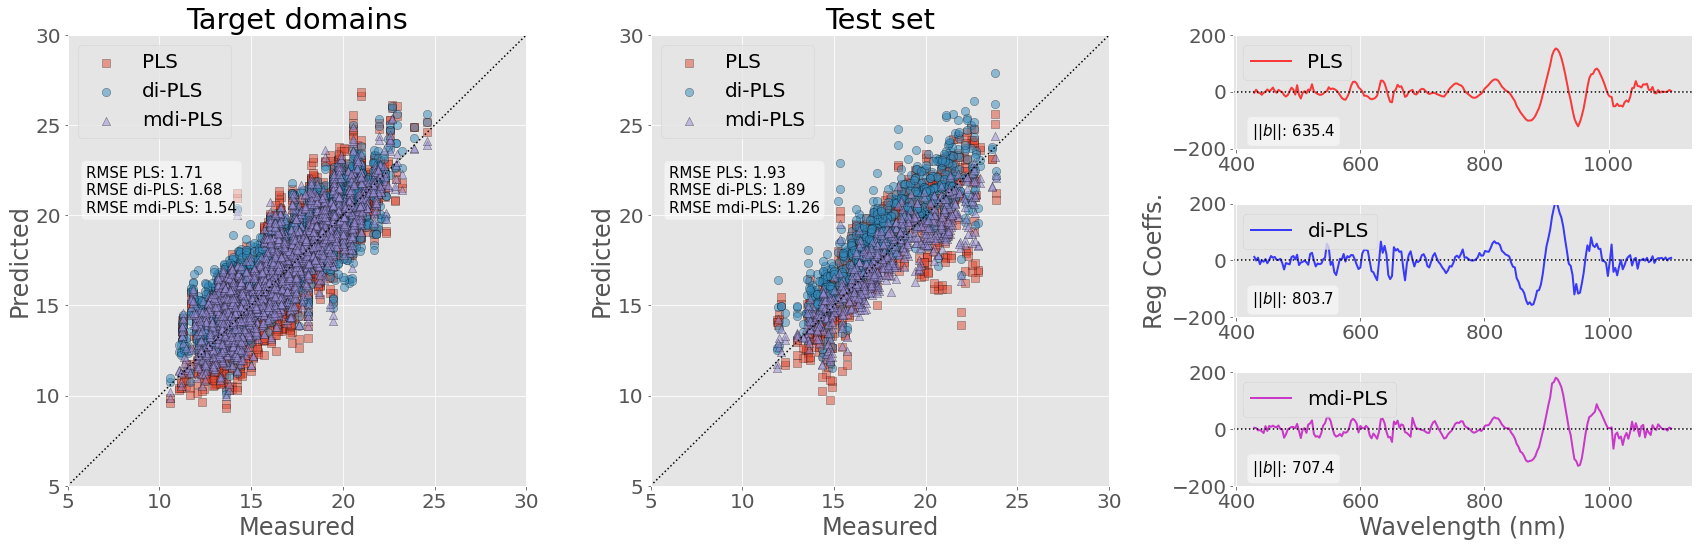

In [249]:
ymin = 5
ymax = 30
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# Predictions (target domains)
yhat_pls, err_pls = m_pls.predict(XX, YY)
yhat_dipls, err_dipls = m_dipls.predict(XX, YY)
yhat_mdipls, err_mdipls = m_mdipls.predict(XX, YY)

# Performance metrics
rmsep_pls, bias_pls, r2p_pls, sep_pls = utils.performance_measures(YY, yhat_pls)
rmsep_dipls, bias_dipls, r2p_dipls, sep_dipls = utils.performance_measures(YY, yhat_dipls)
rmsep_mdipls, bias_mdipls, r2p_mdipls, sep_mdipls = utils.performance_measures(YY, yhat_mdipls)

# Plot
plt.figure(figsize=(24, 8))
plt.subplot(131)
plt.scatter(YY, yhat_pls, edgecolor='k', marker="s", s=70, alpha=0.5, label="PLS")
plt.scatter(YY, yhat_dipls, edgecolor='k', marker="o", s=70, alpha=0.5, label="di-PLS")
plt.scatter(YY, yhat_mdipls, edgecolor='k',marker="^", s=70, alpha=0.5, label="mdi-PLS")
plt.legend(loc=2)
plt.title('Target domains')
ax = plt.gca()
ax.set_xlim([ymin, ymax])
ax.set_ylim([ymin, ymax])
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='k', linestyle=":")
plt.xlabel('Measured')
plt.ylabel('Predicted')
textstr = '\n'.join((
    r'RMSE PLS: %.2f' % (rmsep_pls),
    r'RMSE di-PLS: %.2f' % (rmsep_dipls),
    r'RMSE mdi-PLS: %.2f' % (rmsep_mdipls)))
plt.text(6, 20.0, textstr, fontsize=15,
        verticalalignment='bottom', horizontalalignment='left', bbox=props)

# Predictios (Out-of-domain)
yhat_pls, err_pls = m_pls.predict(Xtar_test, Ytar_test, rescale='Source')
yhat_dipls, err_dipls = m_dipls.predict(Xtar_test, Ytar_test, rescale='Source')
yhat_mdipls, err_mdipls = m_mdipls.predict(Xtar_test, Ytar_test, rescale='Source')

# Performance metrics
rmsep_pls, bias_pls, r2p_pls, sep_pls = utils.performance_measures(Ytar_test, yhat_pls)
rmsep_dipls, bias_dipls, r2p_dipls, sep_dipls = utils.performance_measures(Ytar_test, yhat_dipls)
rmsep_mdipls, bias_mdipls, r2p_mdipls, sep_mdipls = utils.performance_measures(Ytar_test, yhat_mdipls)

# Plot
plt.subplot(132)
plt.scatter(Ytar_test, yhat_pls, edgecolor='k', marker="s", s=70, alpha=0.5, label="PLS")
plt.scatter(Ytar_test, yhat_dipls, edgecolor='k', marker="o", s=70, alpha=0.5, label="di-PLS")
plt.scatter(Ytar_test, yhat_mdipls, edgecolor='k',marker="^", s=70, alpha=0.5, label="mdi-PLS")
plt.legend(loc=2)
plt.title('Test set')
ax = plt.gca()
ax.set_xlim([ymin, ymax])
ax.set_ylim([ymin, ymax])
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='k', linestyle=":")
plt.xlabel('Measured')
plt.ylabel('Predicted')
textstr = '\n'.join((
    r'RMSE PLS: %.2f' % (rmsep_pls),
    r'RMSE di-PLS: %.2f' % (rmsep_dipls),
    r'RMSE mdi-PLS: %.2f' % (rmsep_mdipls)))
plt.text(6, 20.0, textstr, fontsize=15,
        verticalalignment='bottom', horizontalalignment='left', bbox=props)

plt.subplot(333)
plt.plot(wv_range, b_pls, label = "PLS", linewidth = 2, Color='r', alpha=0.75)
#plt.plot(wv_range, b_dipls, label = "di-PLS", linewidth = 2)
#plt.plot(wv_range, b_mdipls, label = "mdi-PLS", linewidth = 2)
#plt.xlabel("Wavelength (nm)")
#plt.ylabel('Reg Coeffs.')
plt.axhline(y=0, color='k', linestyle=':')
plt.ylim([-200,200])
plt.legend(loc=2)
textstr = (r'$||b||$: %.1f' % (np.linalg.norm(b_pls)))
plt.text(425, -175, textstr, fontsize=15,
        verticalalignment='bottom', horizontalalignment='left', bbox=props)
plt.tight_layout()

plt.subplot(336)
#plt.plot(wv_range, b_pls, label = "PLS", linewidth = 2)
plt.plot(wv_range, b_dipls, label = "di-PLS", linewidth = 2, Color='b', alpha=0.75)
#plt.plot(wv_range, b_mdipls, label = "mdi-PLS", linewidth = 2)
#plt.xlabel("Wavelength (nm)")
plt.ylabel('Reg Coeffs.')
plt.ylim([-200,200])
plt.axhline(y=0, color='k', linestyle=':')
plt.legend(loc=2)
textstr = (r'$||b||$: %.1f' % (np.linalg.norm(b_dipls)))
plt.text(425, -175, textstr, fontsize=15,
        verticalalignment='bottom', horizontalalignment='left', bbox=props)
plt.tight_layout()

plt.subplot(339)
#plt.plot(wv_range, b_pls, label = "PLS", linewidth = 2)
#plt.plot(wv_range, b_dipls, label = "di-PLS", linewidth = 2)
plt.plot(wv_range, b_mdipls, label = "mdi-PLS", linewidth = 2, Color='m', alpha=0.75)
plt.xlabel("Wavelength (nm)")
plt.ylim([-200,200])
#plt.ylabel('Reg Coeffs.')
plt.axhline(y=0, color='k', linestyle=':')
plt.legend(loc=2)
textstr = (r'$||b||$: %.1f' % (np.linalg.norm(b_mdipls)))
plt.text(425, -175, textstr, fontsize=15,
        verticalalignment='bottom', horizontalalignment='left', bbox=props)
plt.tight_layout()



plt.savefig("../figures/mango_performance_regcoeffs.png")
plt.show()